## 1.Backgroud


Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It’s a classic “connect three”-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we’re going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. Intuitively, we think remove the first gate from 30 to 40 will increase retention rate because players would have more time to explore the game. However, we should use a/b testing to verify our hypothesis test.During this project, we use the retention rate as key metrics.

Original data is from DataCamp[https://learn.datacamp.com/projects/184] .Here we use p-value approach.

## 2. Design of a/b testing

#### Goal:  Improve retention rate
#### Key metrics: retention rate
#### State Hypothesis:
Null Hypothesis: retention rate at gate_30 = retention rate at gate_40 \
Alternative Hypothesis: retention rate at gate_30 > retention rate at gate_40

#### a/b testing assumption: 
- The factor to test is the only reason for difference
- Each test unit for control/test groups is independent
- Random sampling


#### Assignment units:
Default is user_id,if can no access user_id, we can use device_id or cookie_id\
Here we use user_id


## 3.Data Exploration

In [5]:
import pandas as pd

df = pd.read_csv('datasets/cookie_cats.csv')

df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape

(90189, 5)

The data is collected from 90,189 players who is random picked during a/b testing.\
Variables:
</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>.  </p>

#### Sanity check: 
we would like to see the control group and test group have similar number of units.

In [6]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

From above result,it looks line there is roughly the same number of players in control/test group,the sanity check has passed.

#### Distribution of game rounds during first week

In [9]:
import matplotlib
%matplotlib inline

In [10]:
plot_df = df.groupby(by = 'sum_gamerounds')['userid'].count()

sum_gamerounds
0    3994
1    5538
2    4606
3    3958
4    3629
Name: userid, dtype: int64

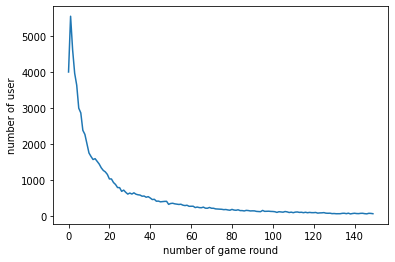

In [17]:
#plot the distribution of number of players that played up to 150 rounds
ax = plot_df.head(n=150).plot(x = 'sum_gamerounds',y = 'userid')
ax.set_xlabel("number of game round")
ax.set_ylabel("number of user")

plot_df.head()

From above plot, we can tell most players just play 1 or 2 rounds(the peak).Some players just download the game and never play the game. The curve is very steep before 20 rounds and becomes flatten after 30 rounds. This is the reason we choose 30 and 40 to do a/b test. At this stage, most players are enjoy the game. We would like to add the gate to enhance in-app purchase or enhance players' enjoyment.

## 4. Test result

#### N-Day Retention rate = $\frac{Number\,of\,users\,that\,launched\,a\,game\,on\,Day\,N}{Number\,of\,users\,who\,installed\,an\,game\,N\,days\,ago}$

#### Overall one-day retention

In [18]:
df["retention_1"].mean()

0.4452095044850259

#### One-day retention for control/test group

In [19]:
df.groupby(by="version")['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

From above mean result, we can tell gate_30 have higher one-day retention rate than gate_40.

#### Overall seven-day retention

In [22]:
df['retention_7'].mean()

0.1860648194347426

In [23]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

From above mean result, we can tell gate_30 have higher seven-day retention rate than gate_40.

Does the result statistics significant? Does the sample can give meaningful inference for population? Let's test the result.

#### P-value approach with pooled proportion

Z-test Statistic = $\frac{\left(\hat{p}_{1}-\hat{p}_{2}\right)-0}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_{1}}+\frac{1}{n_{2}}\right)}}$

Where $\hat{p} = \frac{n_1\hat{p_1} + n_2\hat{p_2}}{n_1+n_2}$

1-day Retention:\
n_1=44700 sample size for group gate_30\
n_2=45489 sample size for group gate_40\
x_1=20034 retention count for group gate_30\
x_2=20119 retention count for group gate_40

7-day Retention:\
n_1=44700 sample size for group gate_30\
n_2=45489 sample size for group gate_40\
x_1=8502 retention count for group gate_30\
x_2=8279 retention count for group gate_40

In [32]:
import scipy.stats
n1=20034
n2=20119
p_pooled=(20034+20119)/(90189)
z_stat_1d=(0.448188-0.442283)/math.sqrt(p_pooled*(1-p_pooled)*(1/n1+1/n2))
print(z_stat_1d)
pvalue_1d=scipy.stats.norm.sf(abs(z_stat_1d))
print(pvalue_1d)

1.190422735778533
0.11694014067197889


Since p value is 0.1169 greater than 0.05, we reject the null hypothesis. There’s enough evidence to support that 1-day retention rate for gate at 30 level is greater than that for gate at 40 level.

In [33]:
n1=8502
n2=8279
p_pooled=(8502+8279)/(90189)
z_stat_7d=(0.190201-0.182000)/math.sqrt(p_pooled*(1-p_pooled)*(1/n1+1/n2))
print(z_stat_7d)
pvalue_7d=scipy.stats.norm.sf(abs(z_stat_7d))
print(pvalue_7d)

1.3648355992175636
0.08615236358155087


Since p value is 0.086 greater than 0.05, we reject the null hypothesis. There’s enough evidence to support that 7-day retention rate for gate at 30 level is greater than that for gate at 40 level.

## 5.  Decision Making and further investigation

#### Decision:
We do not to move the gate from level 30 to level 40 if we want to keep higher retention(both 1-day retention and 7-day retention).

#### Further investigation and lesson learned

- We can also conduct a/b testing for conversion rate(in-app purcahase) or the number of game rounds played.
- Keep players slightly hungry might be a good solution to keep them in a state of permanent.
- Commen sense is not always right, let data help us to make wisely desicion.